In [1]:
import sys
import scipy
import numpy as np
import dask.array as da
import dask.dataframe as dd
import pandas as pd
import matplotlib.pyplot as plt
sys.path.insert(0, "../")
from GWASSimulator import GWASSimulator
%load_ext autoreload
%autoreload 2

In [2]:
gs = GWASSimulator("../data/genotype_data/1000G.EUR.QC.22",
                   keep_snps="../data/w_snplist_no_MHC.snplist.bz2")
gs.simulate()

> Reading genotype files...


Mapping files: 100%|██████████| 3/3 [00:00<00:00,  5.87it/s]


> Computing LD matrices...


/Users/szabad/opt/miniconda3/lib/python3.7/site-packages/dask/array/routines.py:272: PerformanceWarning: Increasing number of chunks by factor of 138
  axes=(left_axes, right_axes),


In [3]:
gs.update_ld_regularization(10.)
gs.simulate(n=1000)

In [15]:
gs.get_p_values()[0].compute()

array([0.81618536, 0.04718362, 0.56398163, ..., 0.16610908, 1.00264266,
       0.020099  ])

In [9]:
g1 = gs.genotypes[0]['G'].compute()
g2 = gs.genotypes[0]['G'].compute()

np.allclose(g1, g2)

True

In [10]:
g1.shape

(1000, 17489)

In [13]:
gs.ld_cholesky_factors[0][0]

<17489x17489 sparse matrix of type '<class 'numpy.float64'>'
	with 8683855 stored elements in Compressed Sparse Column format>

In [17]:
b1 = gs.betas[0].compute()
b2 = gs.betas[0].compute()
np.allclose(b1, b2)

True

In [19]:
np.unique(b2)

array([-2.97993547, -2.940952  , -2.80999501, ...,  3.23195768,
        3.24085518,  3.7718053 ])

In [24]:
import statsmodels.api as sm

y = gs.phenotypes.compute()

pvalues = da.apply_along_axis(lambda x_j: sm.OLS(y, x_j).fit().pvalues,
                              arr=gs.genotypes[0]['G'], axis=0, shape=(gs.genotypes[0]['G'].shape[1],),
                              dtype=float).compute()[0]
with np.errstate(divide='ignore'):
    log10p = -np.log10(pvalues)

In [25]:
log10p

array([0.58012521, 0.30279517, 0.72086382, ..., 0.05881785, 0.00877211,
       0.04168313])

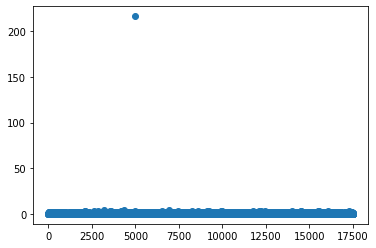

In [49]:
plt.scatter(np.arange(len(gs.p_values[0])), gs.p_values[0].compute())

IndexError: tuple index out of range

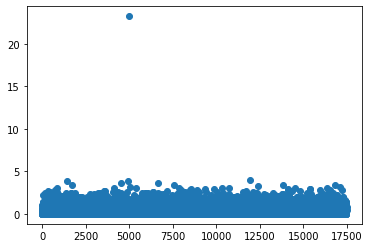

In [98]:
gs.h2g = 0.1 # set heritability
new_beta = np.zeros(gs.betas[0].shape)
new_beta[5000] = 20. # set snp at position 5000 as the only causal snp with effect size of 20.
gs.betas[0] = da.array(new_beta)
gs.simulate() # simulate phenotype

# plot manual p-values
plt.scatter(np.arange(len(gs.p_values[0])), gs.p_values[0].compute())

# compute sm.OLS p-values:
y = gs.phenotypes.compute()
log10p = da.apply_along_axis(lambda x_j: -np.log10(sm.OLS(y, x_j).fit().wald_test(1., use_f=False).pvalue),
                              arr=gs.genotypes[0]['G'], axis=0, shape=(gs.genotypes[0]['G'].shape[1],),
                              dtype=float).compute()[0]
log10p = np.where(log10p > 200, 200, log10p)

# plot sm.OLS p-values    
plt.scatter(np.arange(len(log10p)), log10p)


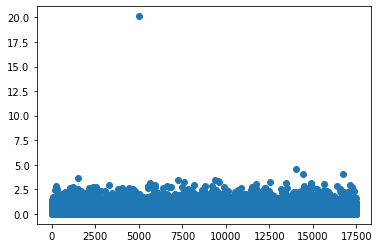

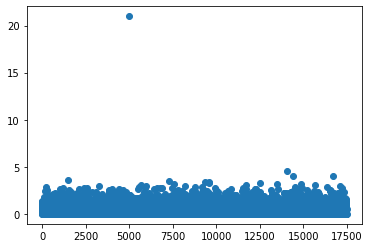

In [63]:
y = gs.phenotypes.compute()

pvalues = da.apply_along_axis(lambda x_j: sm.OLS(y, x_j).fit().pvalues,
                              arr=gs.genotypes[0]['G'], axis=0, shape=(gs.genotypes[0]['G'].shape[1],),
                              dtype=float).compute()[0]
log10p = -np.log10(pvalues)
log10p = np.where(log10p > 200, 200, log10p)
    
plt.scatter(np.arange(len(log10p)), log10p)

In [59]:
pvalues.argmin()

5000

In [99]:
for i in range(gs.genotypes[0]['G'].shape[1]):
    sm.OLS(y, gs.genotypes[0]['G'][:, i].compute()).fit().wald_test(1., use_f=False).pvalue

KeyboardInterrupt: 

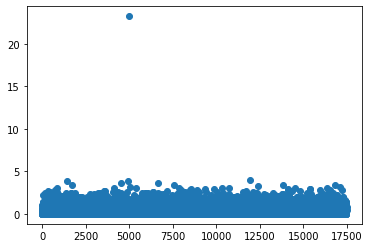

In [102]:
from scipy.stats import chi2
npvals = -np.log10(chi2.sf(gs.z_scores[0]**2, 1))
plt.scatter(np.arange(len(npvals)), npvals)

In [22]:
np.random.geometric(p=(1./20))

10